## End-to-End Machine Learning Pipeline  with Data Analysis
This hands-on lab will guide you through creating an end-to-end machine learning pipeline in Python using Jupyter Notebook. We will cover the following steps:

	1.	Installing and importing necessary libraries.
	2.	Downloading and collecting a dataset.
	3.	Performing and Exploratory Data Analysis
	4.	Processing the data (cleaning and feature engineering).
	5.	Model Development:
		•	Pipeline Setup: We defined a pipeline for data preprocessing, feature engineering, and model training.
		•	Multiple Models: Logistic Regression, Random Forest, and SVM models were tested.
		•	Hyperparameter Tuning: GridSearchCV was used to find the best model and hyperparameters.
		•	Model Evaluation: The best model was evaluated on the test set, and its performance was analyzed.
		•	Inference Pipeline: The best model was saved and loaded into an inference pipeline, which can be deployed via an API for real-time predictions.

### 1. Installing the Libraries

(If you’ve already installed these libraries, you can skip this step.)

In [2]:
# !pip install pandas numpy scikit-learn joblib flask matplotlib seaborn

### 2. Importing the Necessary Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump


### 3. Data Preprocessing
#### A. Data Collection

In [4]:
def get_data():
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer(as_frame=True)
    df = pd.concat([data['data'], data['target']], axis=1)
    return df

# Load the Breast Cancer Wisconsin dataset
data = get_data()

# Display the first few rows
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


#### B. Exploratory Data Analysis (EDA)

Let’s perform some data analysis to understand the distribution of the features and their relationships with the target variable.

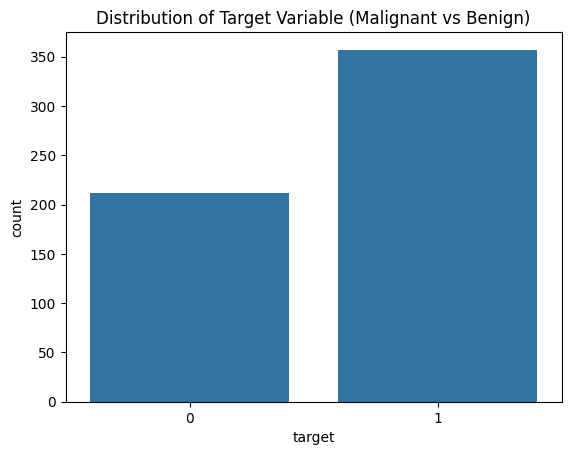

In [5]:
# Distribution of the target variable
sns.countplot(x=data['target'])
plt.title('Distribution of Target Variable (Malignant vs Benign)')
plt.show()


#### C. Mutual information and feature importance:
- mutual_info_classif: This function calculates the mutual information between each feature and the target, which helps in identifying how much information each feature contributes to predicting the target.
- Visualization: The code creates a bar plot to visualize the importance of each feature based on mutual information scores.

#### D. Feature Engineering

In [9]:
def add_combined_feature(X):
    X = X.copy()  # Ensure we're modifying a copy of the DataFrame
    
    # Example feature: combining two features
    X['Combined_radius_texture'] = X['mean radius'] * X['mean texture']
    
    return X

### 3. Model Development

#### A. Build the Training Pipeline

In [10]:
from sklearn.preprocessing import FunctionTransformer

# Define the feature engineering and preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('feature_engineering', FunctionTransformer(add_combined_feature)),
    ('scaler', StandardScaler())
])

# Define the models and their hyperparameters for GridSearchCV
models = [
    {
        'classifier': [LogisticRegression(max_iter=1000)],
        'classifier__C': [0.1, 1.0, 10]
    },
    {
        'classifier': [RandomForestClassifier(random_state=42)],
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 10, 20]
    },
    {
        'classifier': [SVC()],
        'classifier__C': [0.1, 1.0, 10],
        'classifier__kernel': ['linear', 'rbf']
    }
]

# Updated pipeline with additional feature engineering and data transformation steps
training_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipeline),
    ('classifier', LogisticRegression()) # Placeholder, will be replaced by GridSearchCV
])

# Split the data into training and testing sets
X = data.drop(columns=['target'])
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### B. Hyperparameter Tuning and Model Selection

In [11]:
# Use GridSearchCV to find the best model and hyperparameters
grid_search = GridSearchCV(training_pipeline, models, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")

# Best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'classifier': LogisticRegression(max_iter=1000), 'classifier__C': 1.0}
Best cross-validation score: 0.97


#### C. Evaluate the Best Model

In [12]:
def evaluate_model(model, X_test, y_test):

    # Make predictions on the test set
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

Test Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98        63
           1       0.99      0.98      0.99       108

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



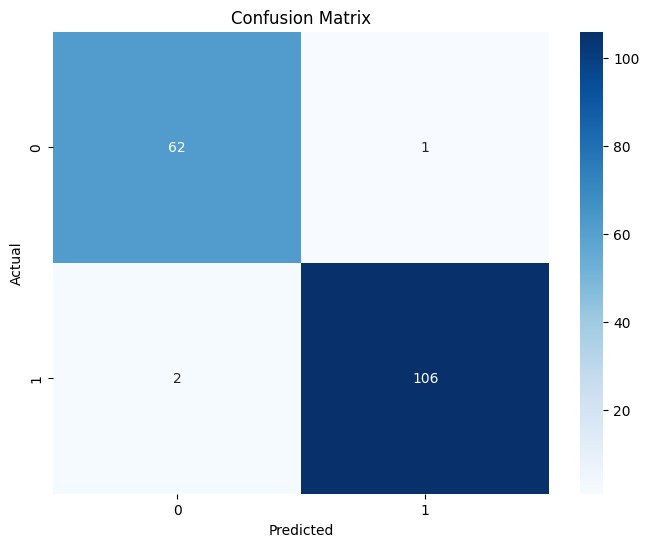

In [13]:
# Evaluate the best Model
evaluate_model(best_model, X_test, y_test)

In [14]:
# Save the best model and the preprocessing steps
dump(best_model, 'best_cancer_model_pipeline.joblib')

['best_cancer_model_pipeline.joblib']

In [16]:
X_test.iloc[0].to_json()

'{"mean radius":12.47,"mean texture":18.6,"mean perimeter":81.09,"mean area":481.9,"mean smoothness":0.09965,"mean compactness":0.1058,"mean concavity":0.08005,"mean concave points":0.03821,"mean symmetry":0.1925,"mean fractal dimension":0.06373,"radius error":0.3961,"texture error":1.044,"perimeter error":2.497,"area error":30.29,"smoothness error":0.006953,"compactness error":0.01911,"concavity error":0.02701,"concave points error":0.01037,"symmetry error":0.01782,"fractal dimension error":0.003586,"worst radius":14.97,"worst texture":24.64,"worst perimeter":96.05,"worst area":677.9,"worst smoothness":0.1426,"worst compactness":0.2378,"worst concavity":0.2671,"worst concave points":0.1015,"worst symmetry":0.3014,"worst fractal dimension":0.0875}'

In [30]:
import requests
def predict():
    return requests.post('http://127.0.0.1:5002/predict', headers={'Content-Type': 'application/json'}, data = X_test.iloc[0].to_json())
print(predict().json()['prediction'] == y_test.iloc[0])

True
